# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import pandas as pd
import numpy as np 
import prettytable as pt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('spanish'))

nltk.download('universal_tagset')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [2]:
dev = pd.read_json('dataset_es_dev.json', lines = True)
test = pd.read_json('dataset_es_test.json', lines = True)
train = pd.read_json('dataset_es_train.json', lines = True)

# Análisis Exploratorio de Datos

In [3]:
cols = pt.PrettyTable()
cols.add_column('DEV', dev.columns.tolist())
cols.add_column('TEST', test.columns.tolist())
cols.add_column('TRAIN', train.columns.tolist())
print(cols)

+------------------+------------------+------------------+
|       DEV        |       TEST       |      TRAIN       |
+------------------+------------------+------------------+
|    review_id     |    review_id     |    review_id     |
|    product_id    |    product_id    |    product_id    |
|   reviewer_id    |   reviewer_id    |   reviewer_id    |
|      stars       |      stars       |      stars       |
|   review_body    |   review_body    |   review_body    |
|   review_title   |   review_title   |   review_title   |
|     language     |     language     |     language     |
| product_category | product_category | product_category |
+------------------+------------------+------------------+


In [4]:
sizes = pt.PrettyTable()
sizes.add_column('DEV', dev.shape)
sizes.add_column('TEST', test.shape)
sizes.add_column('TRAIN', train.shape)
print(sizes)

+------+------+--------+
| DEV  | TEST | TRAIN  |
+------+------+--------+
| 5000 | 5000 | 200000 |
|  8   |  8   |   8    |
+------+------+--------+


In [5]:
dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [6]:
dev.review_body = dev.review_body.apply(lambda x: x.lower())
dev.review_title = dev.review_title.apply(lambda x: x.lower())

<AxesSubplot:>

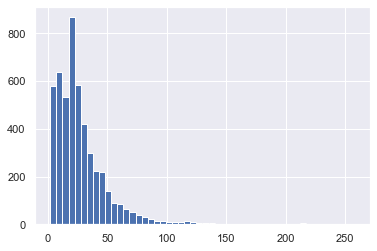

In [9]:
# Numero de palabras en el review
words_per_review = dev.review_body.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 50)

In [10]:
words_per_review.mean()

27.572

In [13]:
dev.stars.value_counts()
#perfectly balanced as all things should be

4    1000
1    1000
5    1000
2    1000
3    1000
Name: stars, dtype: int64

In [14]:
dev['binario'] = np.where(dev.stars > 3, 1, 0)
dev['binario'].value_counts()

0    3000
1    2000
Name: binario, dtype: int64

In [ ]:
# Removing neutral reviews 
# amazon_reviews = amazon_reviews[amazon_reviews.Score != 3]

In [18]:
def tokenizar(df):

	new_df = df[['review_id','stars','review_body','review_title']]

	new_df['body_token'] = new_df.review_body.apply(lambda x: nltk.tokenize.word_tokenize(x))
	new_df['title_token'] = new_df.review_title.apply(lambda x: nltk.tokenize.word_tokenize(x))

	characters = [',', '.', '!', '¡', '?', '¿' , '@', '...']

	for column in ['body_token', 'title_token']:
		for i in range(len(new_df.body_token)):
			new_df[column][i] = [word for word in new_df[column][i] if word not in characters]
			new_df[column][i] = [word for word in new_df[column][i] if word not in stopwords]

	return new_df

In [51]:
dev_token = tokenizar(dev)
#test_token = tokenizar(test)
#train_token = tokenizar(train)

In [59]:
dev_token.head(3)

,review_id,stars,review_body,review_title,body_token,title_token,body_lemma
0,es_0417480,1,"malisimo, muy grande demasiado aparatoso y mal...",mala compra,"[malisimo, grande, demasiado, aparatoso, mal, ...","[mala, compra]","[malisimo, grande, demasiado, aparatoso, mal, ..."
1,es_0180432,1,no he recibido el pedido no la devolución,no lo he recibido,"[recibido, pedido, devolución]",[recibido],"[recibido, pedido, devolución]"
2,es_0144850,1,"tengo que buscar otro sistema, este no funcion...",que no aprieta bien en el manillar,"[buscar, sistema, funciona, bien, abrazadera, ...","[aprieta, bien, manillar]","[buscar, sistema, funcionar, bien, abrazaderar..."


In [42]:
import spacy

spacy.prefer_gpu()
nlp = spacy.load("es_core_news_sm")

In [45]:
doc = nlp('como funciona y esta monda')
for token in doc:
    print(token, token.text, token.pos_, token.lemma_)

como como SCONJ como
funciona funciona NOUN funciona
y y CCONJ y
esta esta DET este
monda monda NOUN monda


In [58]:
dev_token['body_lemma'] = dev_token.body_token.apply(lambda x: ' '.join(x))
dev_token['body_lemma'] = dev_token.body_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])

In [61]:
dev_token['title_lemma'] = dev_token.title_token.apply(lambda x: ' '.join(x))
dev_token['title_lemma'] = dev_token.title_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])

In [30]:
#from nltk.stem import WordNetLemmatizer 
#wordnet_lemmatizer = WordNetLemmatizer() 
#wordnet_lemmatizer.lemmatize()
#get_wordnet_pos(palabra) 

In [ ]:
#from nltk.corpus import wordnet

#def get_wordnet_pos(word):
 #   """Map POS tag to first character lemmatize() accepts"""
  #  tag = nltk.pos_tag([word])[0][1][0].upper()
   # tag_dict = {"J": wordnet.ADJ,
    #            "N": wordnet.NOUN,
     #           "V": wordnet.VERB,
      #          "R": wordnet.ADV}

    #return tag_dict.get(tag, wordnet.NOUN)


In [21]:
#nltk.pos_tag(['recibido'], tagset='universal')

[('recibido', 'NOUN')]

In [54]:
#dev_token.body_token = dev_token.body_token.apply(lambda x: [stemmer.stem(each_string) for each_string in x])
#dev_token.title_token = dev_token.title_token.apply(lambda x: [stemmer.stem(each_string) for each_string in x])

In [ ]:
#from nltk.stem import SnowballStemmer
#stemmer = SnowballStemmer("spanish") # Choose a language
#stemmer.stem()

In [62]:
def get_freqs(df):

	# Separamos las reseñas malas de las buenas
	df_malos = df.loc[df.stars.isin([1,2,3])]
	df_buenos = df.loc[df.stars.isin([4,5])]

	df_malos.reset_index(inplace= True)
	df_buenos.reset_index(inplace= True)

	# Guardamos todos los titulos y reseñas buenos y malos en listas separadas
	df_malos_titulos = []
	df_malos_reviews = []
	for i in range(len(df_malos.review_title)):
		df_malos_titulos.append(df_malos.title_lemma[i])
		df_malos_reviews.append(df_malos.body_lemma[i])
	df_malos_titulos = [item for elem in df_malos_titulos for item in elem]
	df_malos_reviews = [item for elem in df_malos_reviews for item in elem]

	df_buenos_titulos = []
	df_buenos_reviews = []
	for i in range(len(df_buenos.review_title)):
		df_buenos_titulos.append(df_buenos.title_lemma[i])
		df_buenos_reviews.append(df_buenos.body_lemma[i])
	df_buenos_titulos = [item for elem in df_buenos_titulos for item in elem]
	df_buenos_reviews = [item for elem in df_buenos_reviews for item in elem]

	# Hacemos 4 dataframes con las frecuencias de las palabras
	df_malos_titulos_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_malos_titulos), orient = 'index')
	df_malos_titulos_freq['word'] = df_malos_titulos_freq.index
	df_malos_titulos_freq.sort_values(by = 0, ascending= False, inplace = True)

	df_malos_reviews_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_malos_reviews), orient = 'index')
	df_malos_reviews_freq['word'] = df_malos_reviews_freq.index
	df_malos_reviews_freq.sort_values(by = 0, ascending= False, inplace = True)

	df_buenos_titulos_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_buenos_titulos), orient = 'index')
	df_buenos_titulos_freq['word'] = df_buenos_titulos_freq.index
	df_buenos_titulos_freq.sort_values(by = 0, ascending= False, inplace = True)
	
	df_buenos_reviews_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_buenos_reviews), orient = 'index')
	df_buenos_reviews_freq['word'] = df_buenos_reviews_freq.index
	df_buenos_reviews_freq.sort_values(by = 0, ascending= False, inplace = True)

	return df_malos_titulos_freq, df_malos_reviews_freq, df_buenos_titulos_freq, df_buenos_reviews_freq

In [63]:
dev_mal_tit, dev_mal_rev, dev_buen_tit, dev_buen_rev = get_freqs(dev_token)

In [60]:
#dev_token.loc[(dev_token.title_token.apply(lambda x: 'calid' in x))]

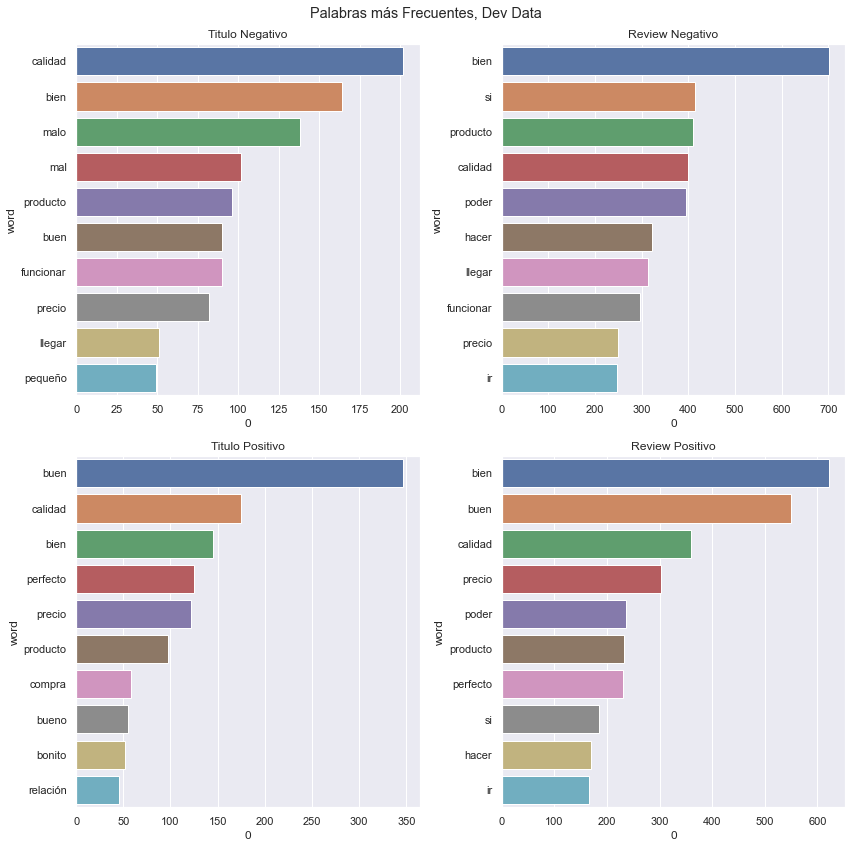

In [64]:
plt.figure(figsize= (12,12))
plt.suptitle('Palabras más Frecuentes, Dev Data')

plt.subplot(221)
sns.barplot(x = dev_mal_tit[0][:10], y = dev_mal_tit.word[:10])
plt.title('Titulo Negativo')

plt.subplot(222)
sns.barplot(x = dev_mal_rev[0][:10], y = dev_mal_rev.word[:10])
plt.title('Review Negativo')

plt.subplot(223)
sns.barplot(x = dev_buen_tit[0][:10], y = dev_buen_tit.word[:10])
plt.title('Titulo Positivo')

plt.subplot(224)
sns.barplot(x = dev_buen_rev[0][:10], y = dev_buen_rev.word[:10])
plt.title('Review Positivo')

plt.tight_layout();